# Setup

In [33]:
import numpy as np
import pandas as pd
import networkx as nx

import seaborn as sns

sns.set_style('ticks')
sns.set_context('notebook')
sns.set(rc={'figure.dpi': 300, 'savefig.dpi': 300})

import matplotlib.pyplot as plt
import matplotlib.colors as clr

plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

from graph.data import *
from graph.network import *
from graph.temporal import *
from graph.utils import *

# import graph.data
# import graph.network
# import graph.temporal
# import graph.utils

In [2]:
# import importlib
# importlib.reload(graph.data)
# importlib.reload(graph.network)
# importlib.reload(graph.temporal)
# importlib.reload(graph.utils)

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
# phonelab_to_db()

In [5]:
# phonelab_sp(
#     folder_in=['/home/ali/Projects/Network/data/phonelab/db'],
#     file_in=['phonelab.db'],
#     label_folder_in='',
#     label_file_in='connect'
# )

# phonelab_sp(label_file_in='connect')

In [6]:
# M = np.load('/home/ali/Projects/Network/data/phonelab/data/user_ssid_connect.npy')
# sM = sparse.csc_matrix(M)

In [7]:
# sM = sparse.load_npz('/home/ali/Projects/Network/data/phonelab/data/user_ssid_connect_sparse.npz')
sM = sparse.load_npz('/home/ali/Projects/Network/data/phonelab/data/user_day_ssid_connect_sparse.npz')
M = sM.toarray()

In [8]:
from sklearn.preprocessing import MaxAbsScaler

min_max_scaler = MaxAbsScaler()
M_minmax = min_max_scaler.fit_transform(M)
print(M_minmax.shape)

# min_max_scaler = MaxAbsScaler()
# sM_minmax = min_max_scaler.fit_transform(sM)
# print(sM_minmax.shape)

(19144, 28224)


In [9]:
# from sklearn.preprocessing import StandardScaler

# standard_scaler = StandardScaler()
# M_standard = standard_scaler.fit_transform(M)

In [16]:
# Take really long time -> calculated at compute canada
# cov_mat = np.cov(M_minmax.T)
# eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)

In [35]:
# print(cov_mat.shape)
# print(eigen_vals.shape)
# print(eigen_vecs.shape)

In [9]:
# sE = sparse.load_npz('/home/ali/Projects/Network/data/phonelab/data/user_ssid_connect_eigen_vecs_sparse.npz')
sE = sparse.load_npz('/home/ali/Projects/Network/data/phonelab/data/user_ssid_connect_eigen_vecs_sparse.npz')
E = sE.toarray()

In [10]:
# V = np.load('/home/ali/Projects/Network/data/phonelab/data/user_ssid_connect_eigen_vals.npy')
V = np.load('/home/ali/Projects/Network/data/phonelab/data/user_day_ssid_connect_eigen_vals.npy')

In [11]:
tot = sum(V)
var_exp = np.array([(i / tot) for i in sorted(V, reverse=True)])
cum_var_exp = np.cumsum(var_exp)

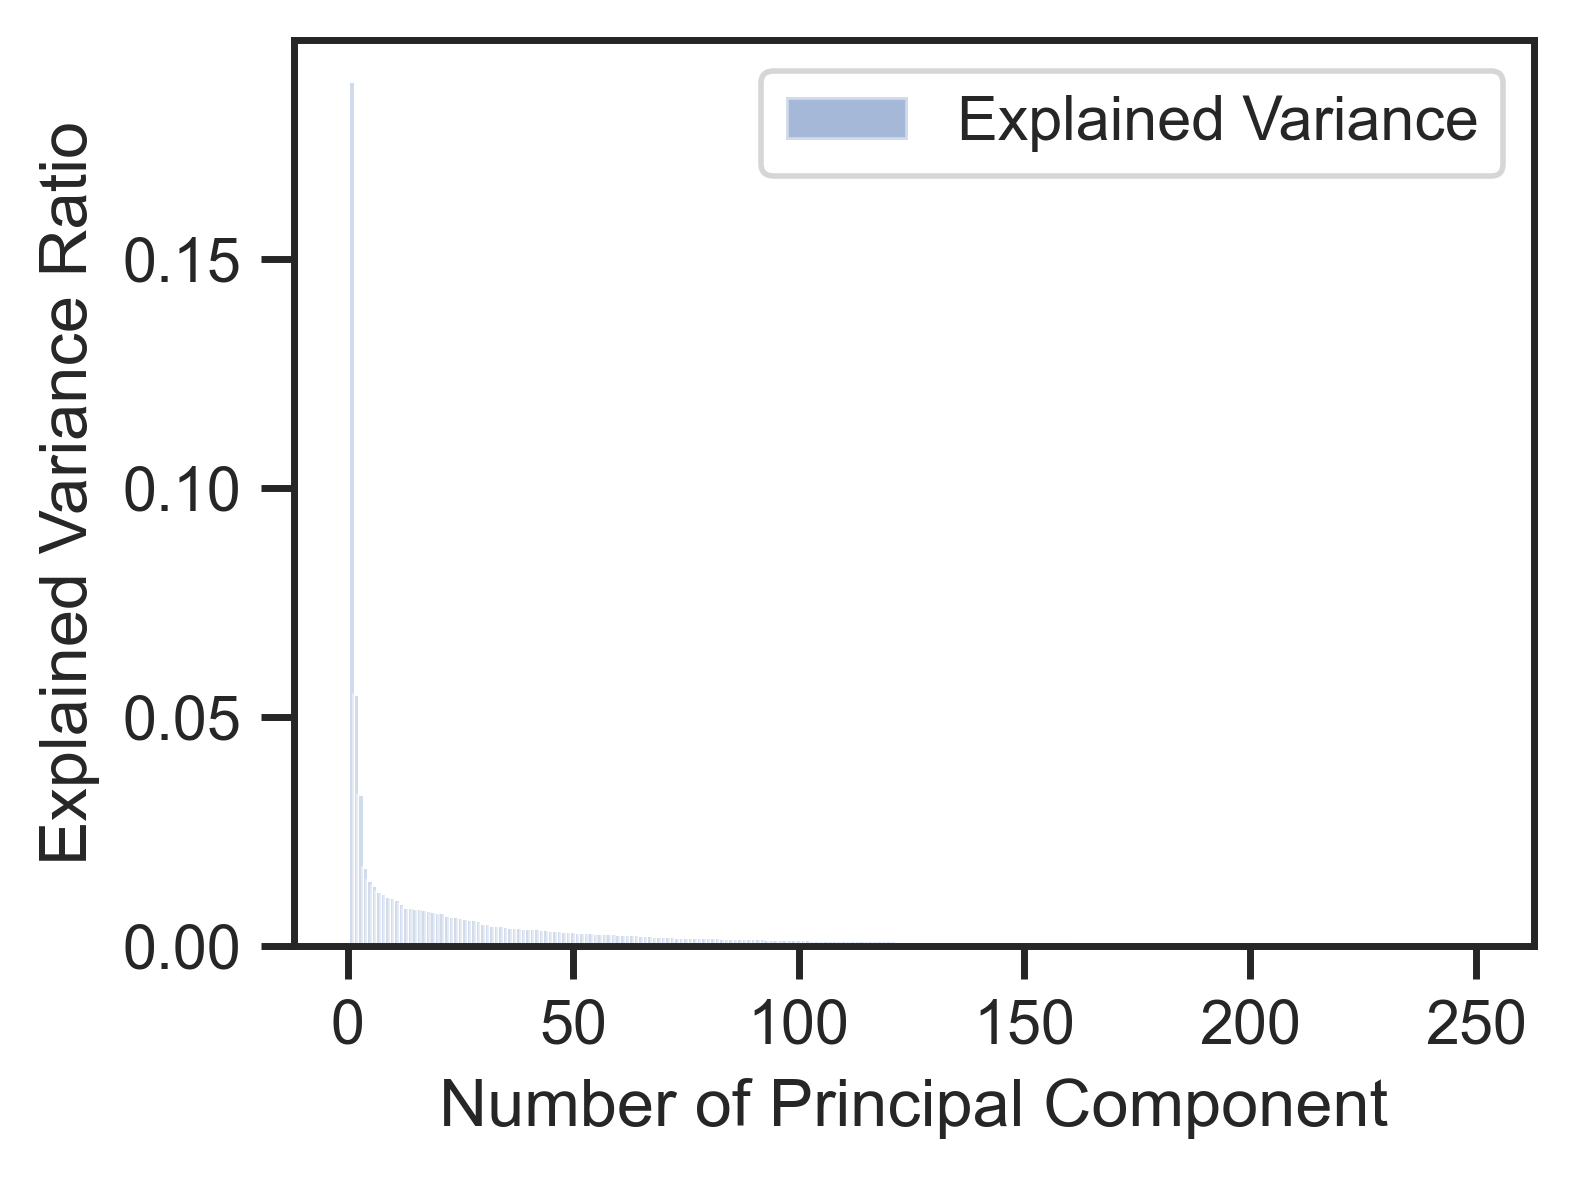

In [12]:
plt.figure(figsize=(4, 3), dpi=400)
plt.bar(range(1, 251),
        var_exp[:250].real,
        alpha=0.5,
        align='center',
        label='Explained Variance')
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Number of Principal Component')
plt.legend(loc='best')
PATH = os.path.join(DATA, 'pca_variance_ratio.pdf')
# plt.savefig(PATH, dpi=400)
plt.show()

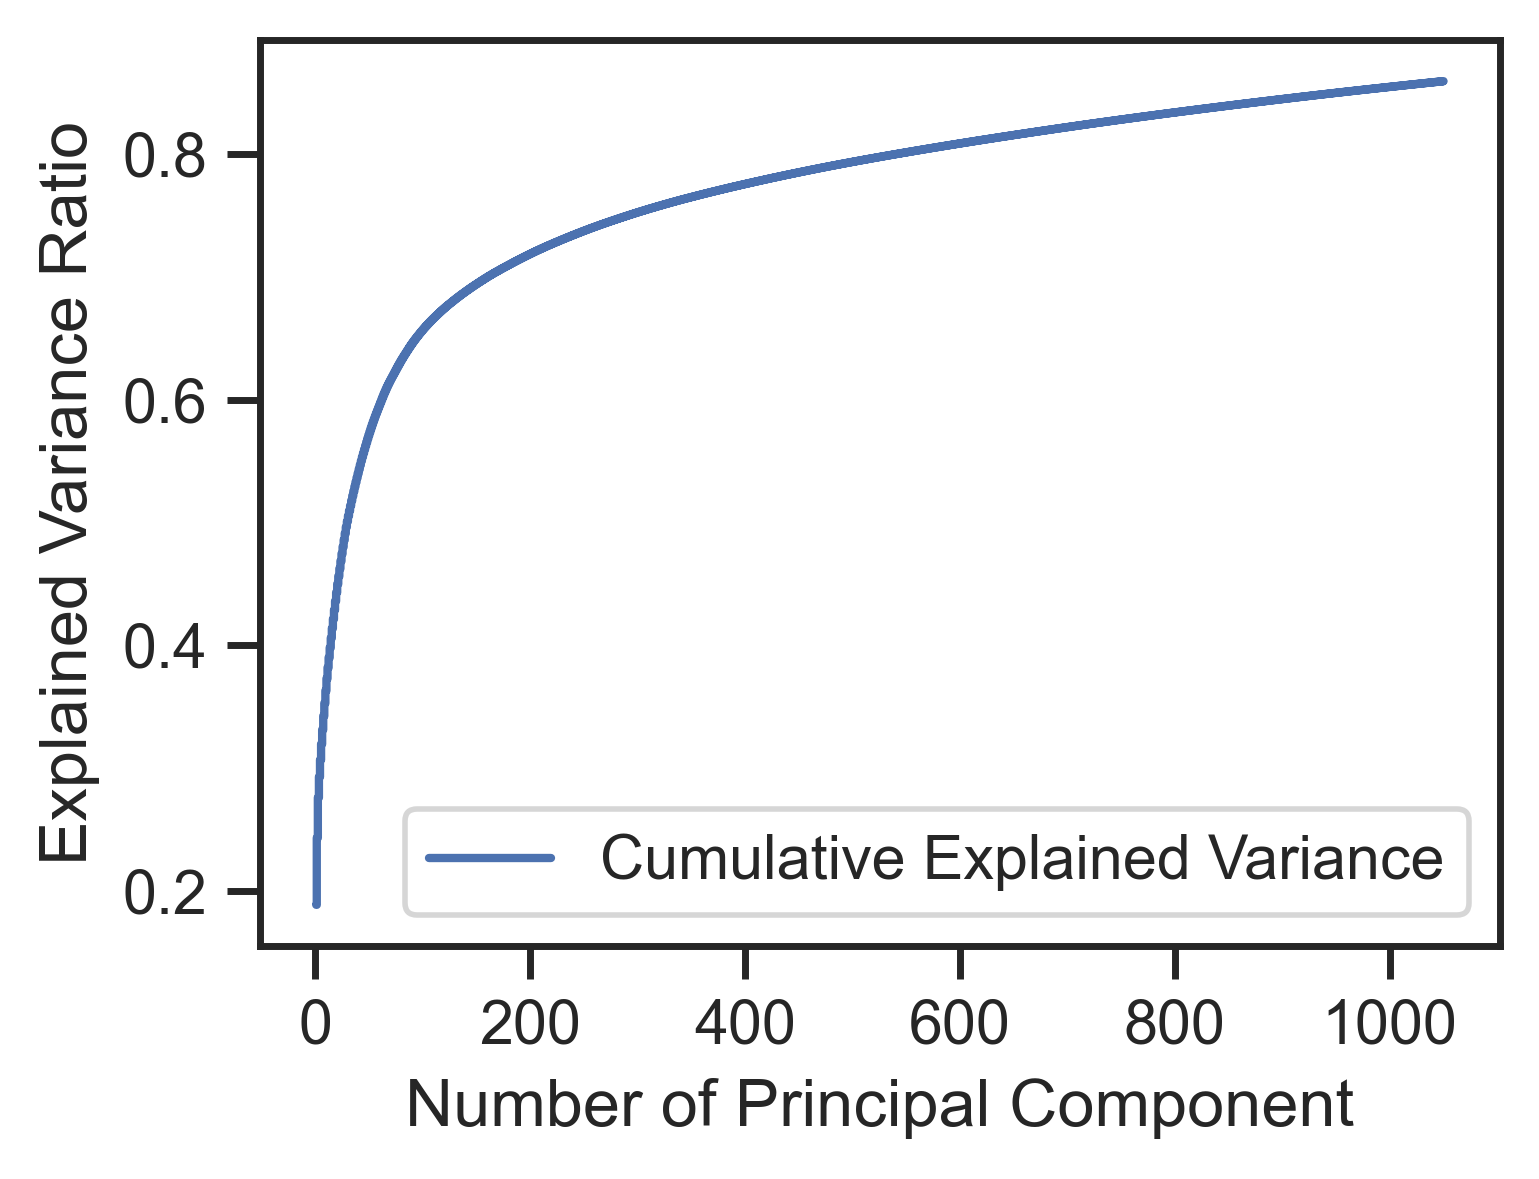

In [18]:
plt.figure(figsize=(4, 3), dpi=400)
plt.step(range(1, 1051),
            cum_var_exp[0:1050].real,
            where='mid',
            label='Cumulative Explained Variance')
# plt.plot(cum_var_exp)
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Number of Principal Component')
plt.legend(loc='best')
PATH = os.path.join(DATA, 'pca_variance_ratio.pdf')
# plt.savefig(PATH, dpi=400)
plt.show()

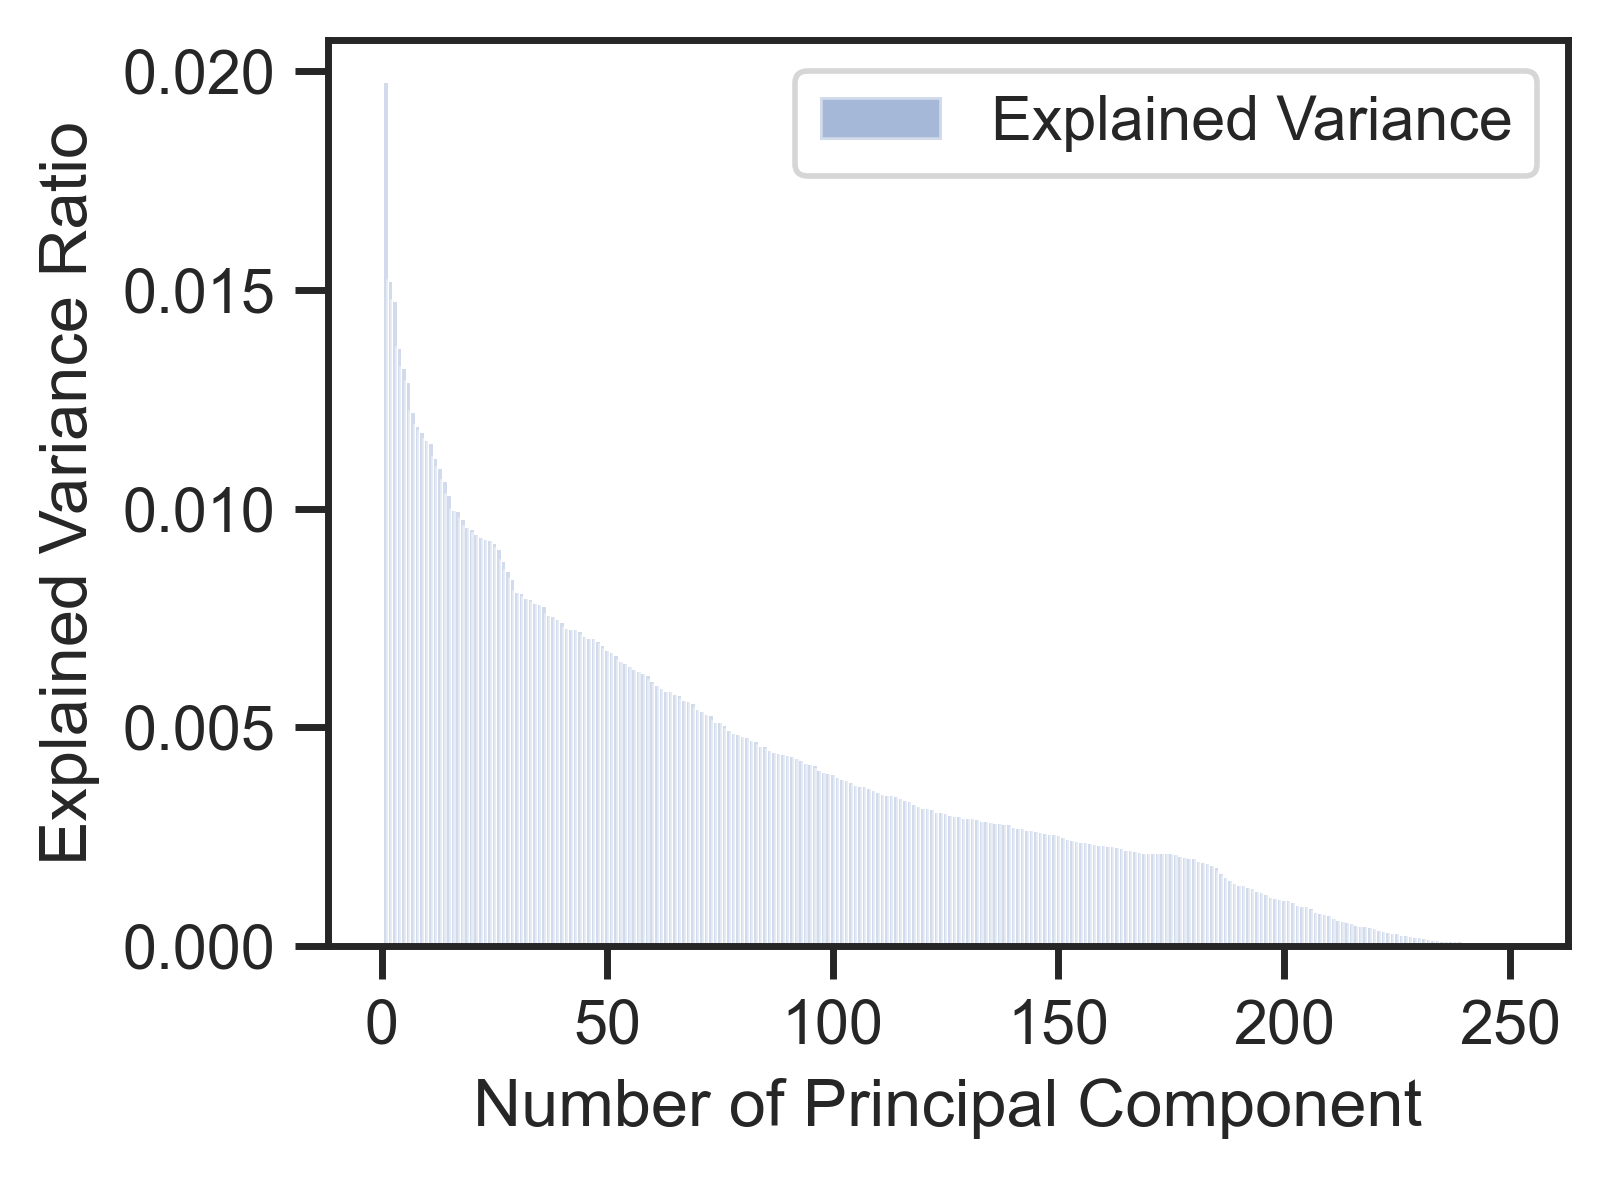

In [37]:
plt.figure(figsize=(4, 3), dpi=400)
plt.bar(range(1, 251),
        var_exp[:250].real,
        alpha=0.5,
        align='center',
        label='Explained Variance')
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Number of Principal Component')
plt.legend(loc='best')
PATH = os.path.join(DATA, 'pca_variance_ratio.pdf')
# plt.savefig(PATH, dpi=400)
plt.show()

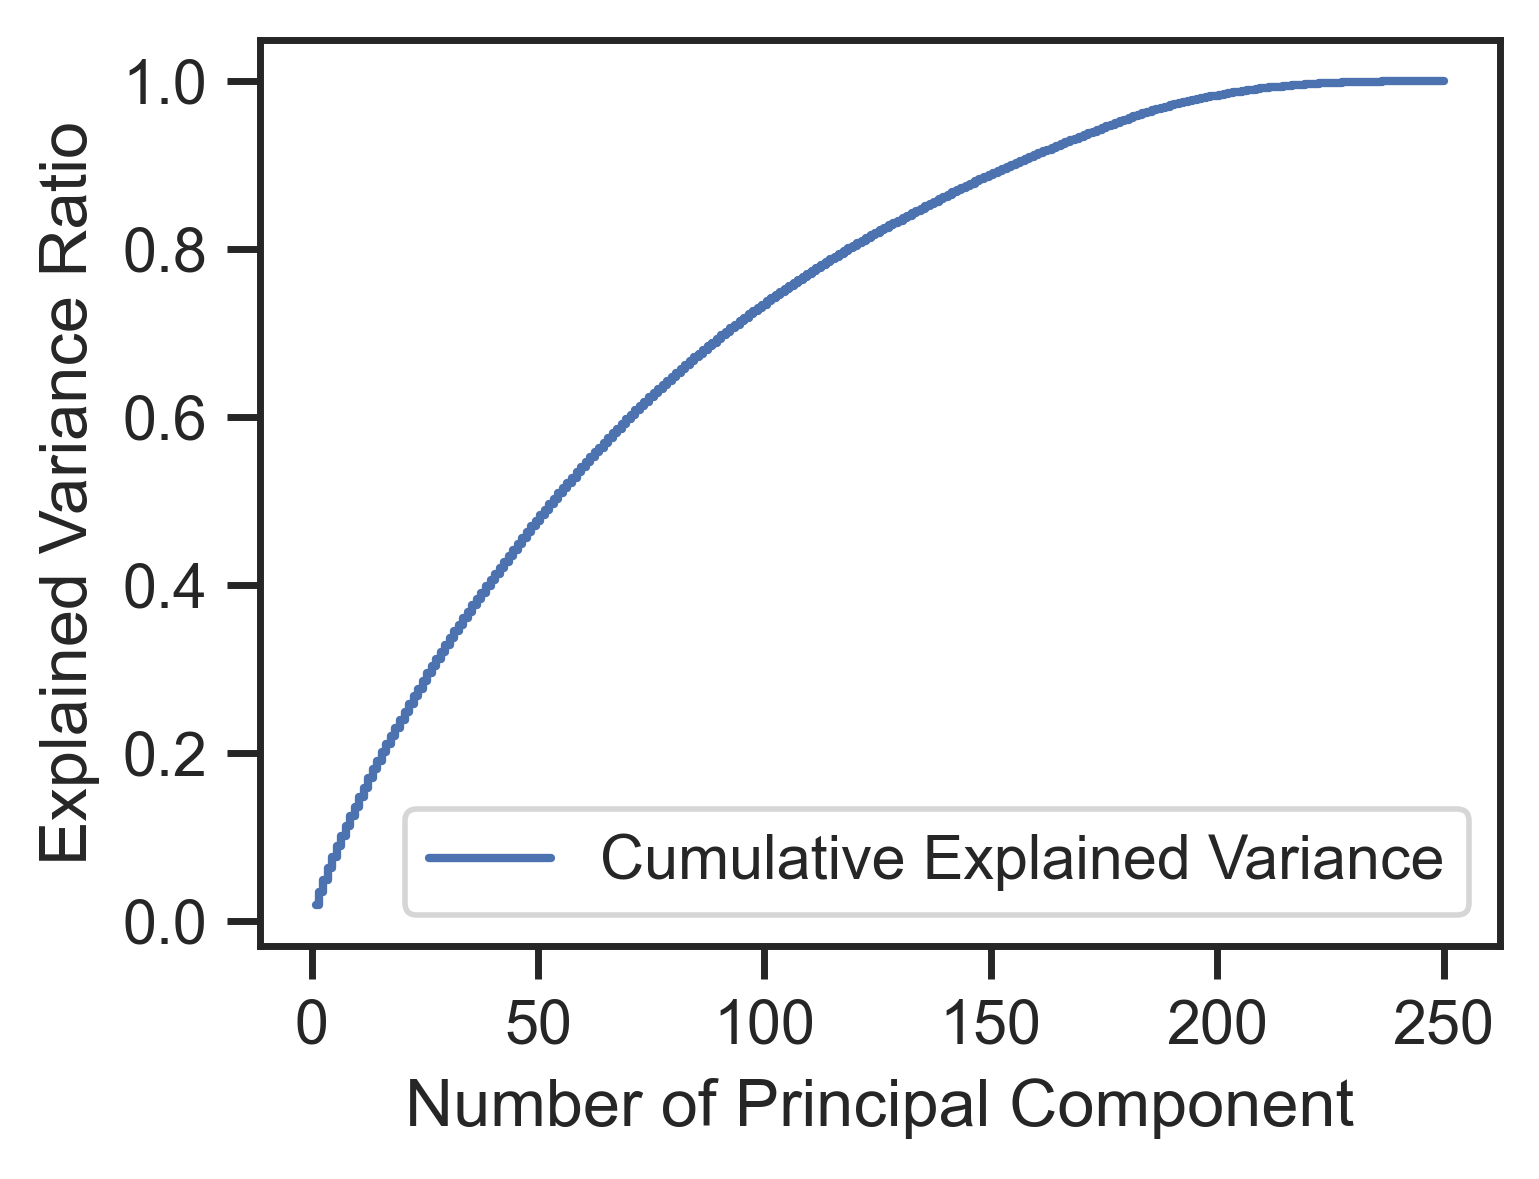

In [38]:
plt.figure(figsize=(4, 3), dpi=400)
plt.step(range(1, 251),
            cum_var_exp[0:250].real,
            where='mid',
            label='Cumulative Explained Variance')
# plt.plot(cum_var_exp)
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Number of Principal Component')
plt.legend(loc='best')
PATH = os.path.join(DATA, 'pca_variance_ratio.pdf')
# plt.savefig(PATH, dpi=400)
plt.show()

In [19]:
eigen_pairs = [(np.abs(V[i]), E[:, i]) for i in range(len(V))]
eigen_pairs.sort(key=lambda k: k[0], reverse=True)

In [40]:
# idx = eigen_vals.argsort()[::-1]   
# eigen_vals = eigen_vals[idx]
# eigen_vecs = eigen_vecs[:,idx]
# eigen_pairs = (eigen_vals, eigen_vecs)

In [20]:
component_number = 2
W = np.concatenate(
    [eigen_pairs[i][1][:, np.newaxis] for i in range(component_number)],
    axis=1
)

In [21]:
W.shape

(28224, 2)

In [22]:
# M_new = np.dot(M_minmax, W)
M_new = M_minmax @ W

# file_name = f'/home/ali/Projects/Network/data/phonelab/data/user_ssid_connect_transformed_{component_number}.npy'
# np.save(file_name, M_new)

In [23]:
M_new.shape

(19144, 2)

In [171]:
PATH = '/home/ali/Projects/Network/data/phonelab/data/user_day_ssid_connect_label.csv'
M_labels = pd.read_csv(PATH, index_col=False, header=None, names=['label']).iloc[:, 0]

Calculate the distribution of classes

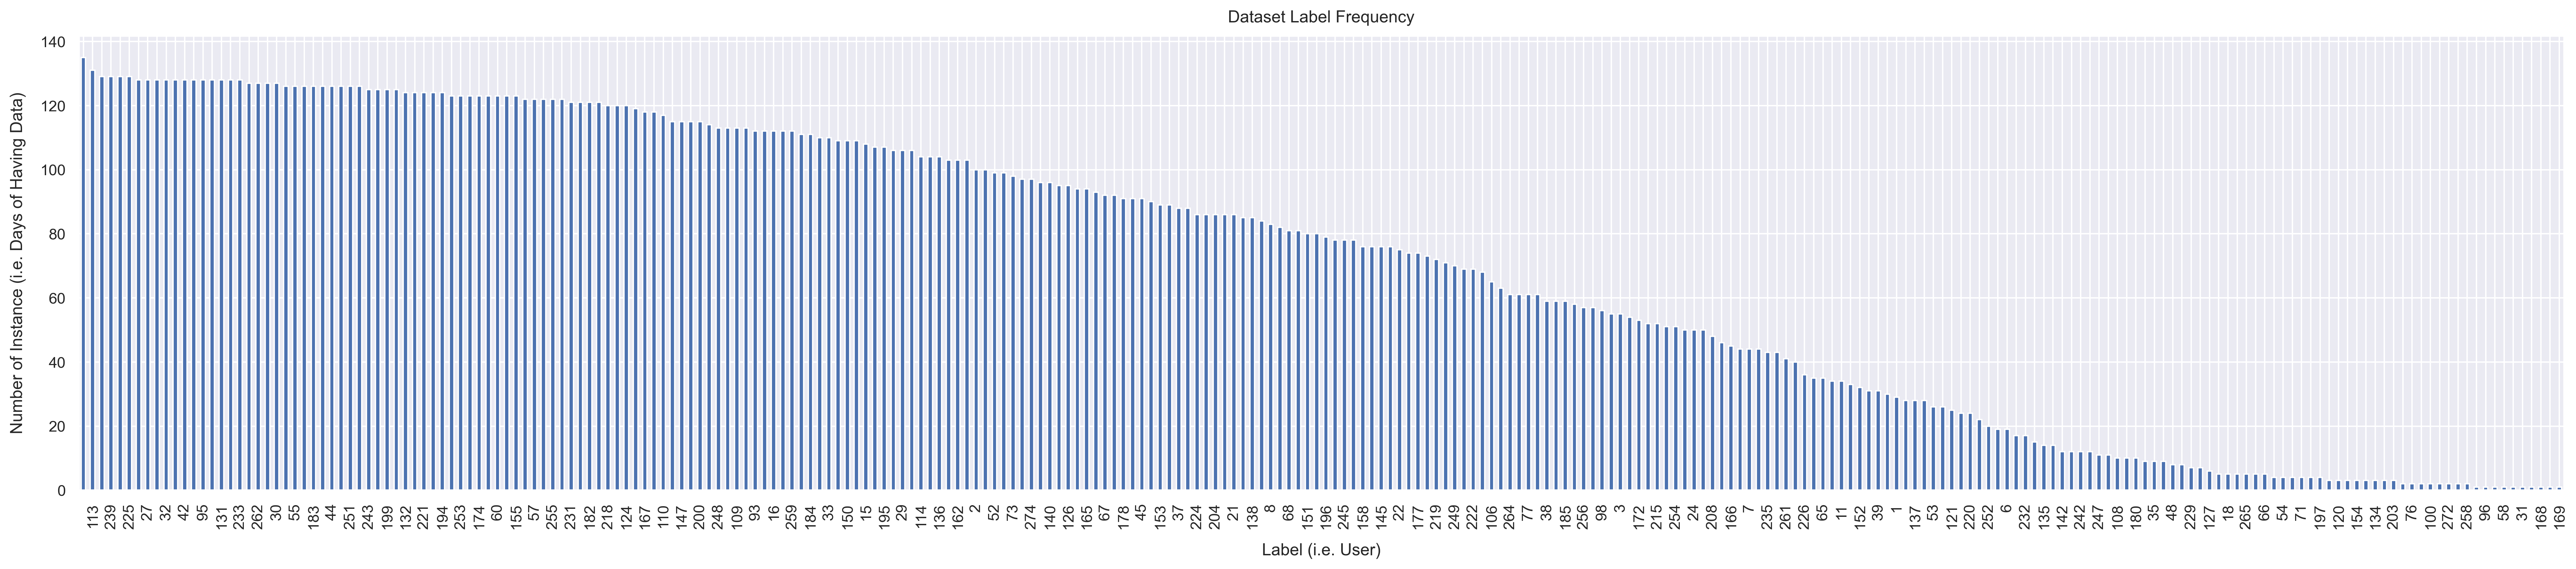

In [242]:
M_labels.value_counts().plot(kind='bar', figsize=(32, 6), rot=90)
# plt.xticks(rotation=90)
# Remoce odd X ticks
ax=plt.gca()
for label in ax.get_xaxis().get_ticklabels()[::2]:
    label.set_visible(False)
plt.xlabel('Label (i.e. User)', labelpad=10)
plt.ylabel('Number of Instance (i.e. Days of Having Data)', labelpad=10)
plt.title('Dataset Label Frequency', pad=10);

In [38]:
my_cmap = clr.LinearSegmentedColormap.from_list('my_cmap',[(0, 'skyblue'),(0.25, 'aqua'),(0.5, 'royalblue'),(0.75, 'darkblue'),(1, 'black')],N=len(M_labels.unique()))

In [54]:
my_cmap = sns.color_palette('rocket',n_colors=len(M_labels.unique()),as_cmap=True)

In [156]:
def discrete_cmap(N, base_cmap=None):
    '''Create an N-bin discrete colormap from the specified input map'''

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

/home/ali/Anaconda/lib/python3.8/site-packages/numpy/core/_asarray.py:171: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


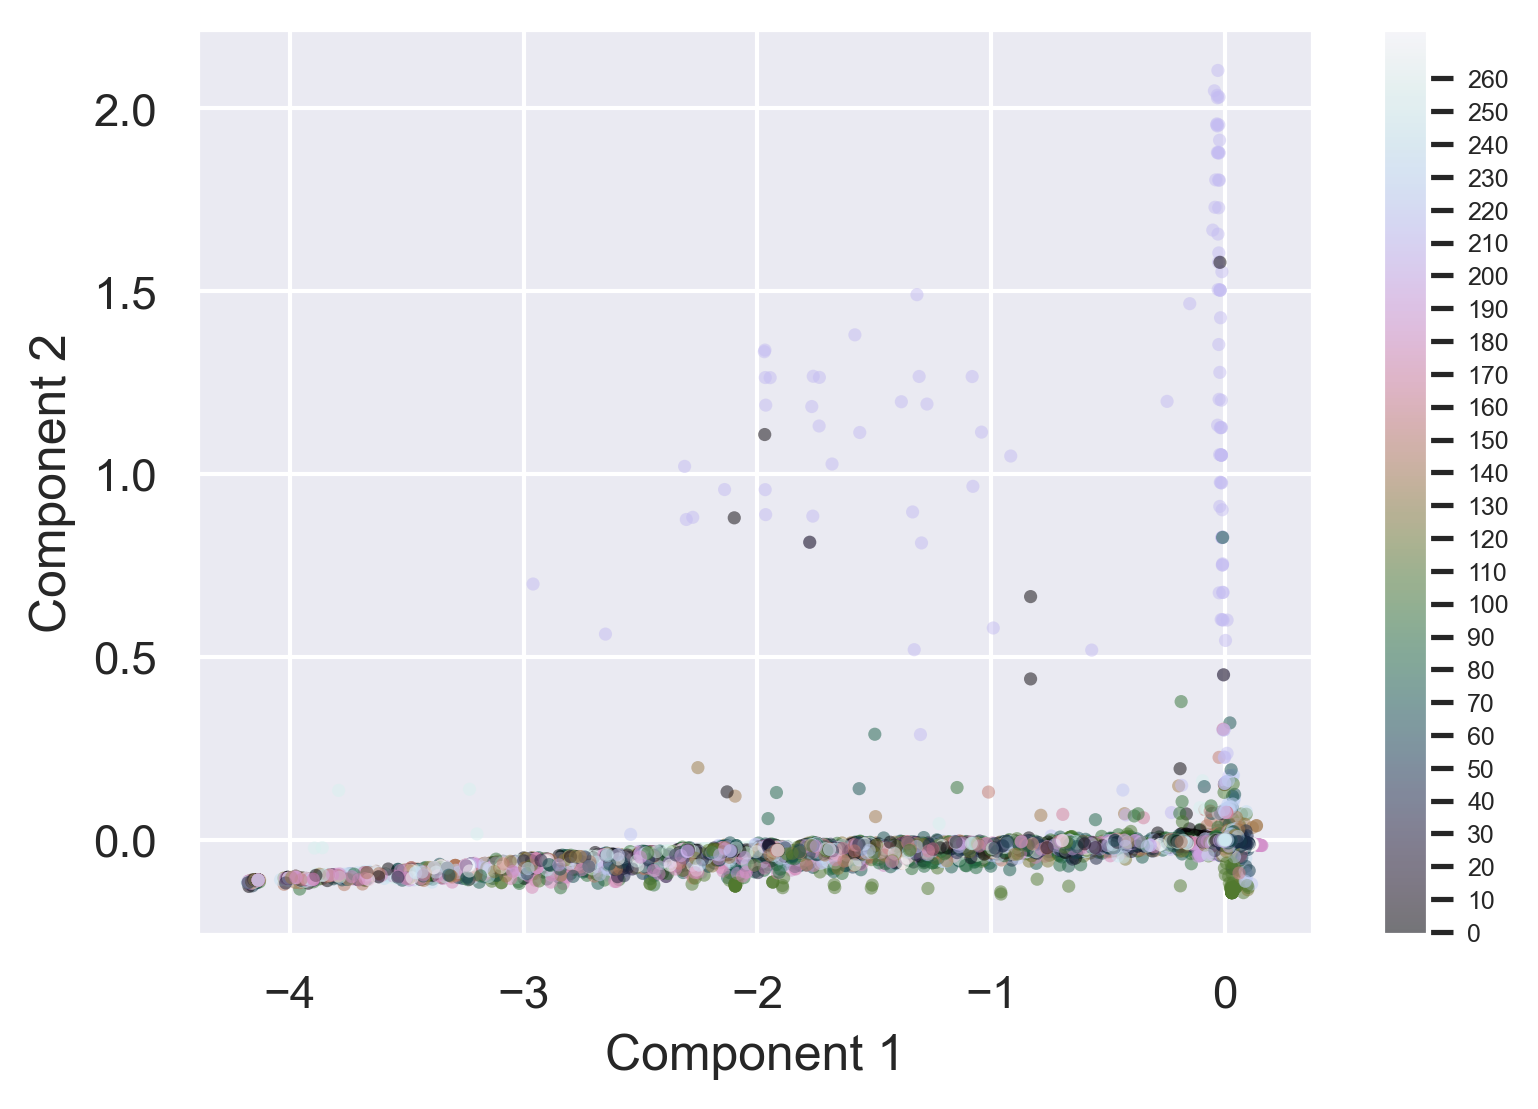

In [163]:
N = len(M_labels.unique())
plt.scatter(
    M_new[:, 0],
    M_new[:, 1],
    c=M_labels,
    edgecolor='none',
    alpha=0.5,
    s=10,
    # cmap=plt.cm.get_cmap('spectral', 10) # Only if we have 10 classes
    # cmap=plt.cm.get_cmap('viridis')
    cmap = discrete_cmap(N, 'cubehelix')
    # cmap = my_cmap
)
plt.xlabel('Component 1')
plt.ylabel('Component 2')
# plt.colorbar()
cbar = plt.colorbar(ticks=range(0,N,10))
cbar.ax.tick_params(labelsize=6)

In [68]:
df = pd.DataFrame(np.concatenate((M_new.real, M_labels[:, np.newaxis]), axis=1),columns=['cp1','cp2','label'])

/tmp/ipykernel_681549/1392924346.py:1: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = pd.DataFrame(np.concatenate((M_new.real, M_labels[:, np.newaxis]), axis=1),columns=['cp1','cp2','label'])


# Clustering on Dataset After PCA

Let's create dataframe from transformed data after PCA

In [262]:
df = pd.DataFrame(
    data=M_new.real, columns=['pc' + str(i) for i in range(M_new.shape[1])]
)
df['target'] = M_labels.astype(int)

In [263]:
df.head()

,pc0,pc1,target
0,-0.186998,-0.011642,245
1,-0.408995,-0.020289,245
2,-0.021339,-0.001319,20
3,-0.004186,-0.001234,107
4,0.019179,-0.017072,245


A few of classes (i.e. labels) has only 1 instance which could affect the prediction. So we can (optionally) remove these to improve the classification

In [264]:
M_labels_counts = df['target'].value_counts()
print(M_labels_counts[M_labels_counts < 2].index)

df.drop(
    df[df['target'].isin(M_labels_counts[M_labels_counts < 2].index)].index,
    inplace=True
)

# M_labels_counts = df['target'].value_counts()
# print(M_labels_counts[M_labels_counts < 2].index)

Int64Index([13, 96, 263, 58, 84, 31, 91, 168, 266, 169], dtype='int64')
Int64Index([], dtype='int64')


Split dataset into training and test sets (while considering distribution of classes)

In [269]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(
    df, test_size=0.2, random_state=1, stratify=df['target']
)

# print(train_set['target'].value_counts() / len(train_set))
# print(test_set['target'].value_counts() / len(test_set))

Another way of dataset split

In [268]:
# from sklearn.model_selection import StratifiedShuffleSplit

# strat_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=1)
# for train_index, test_index in strat_split.split(df, df['target']):
#     train_set = df.iloc[train_index]
#     test_set = df.iloc[test_index]

# print(train_set['target'].value_counts() / len(train_set))
# print(test_set['target'].value_counts() / len(test_set))

81     0.007056
113    0.006860
239    0.006729
111    0.006729
46     0.006729
         ...   
23     0.000131
179    0.000131
133    0.000131
227    0.000131
76     0.000131
Name: target, Length: 260, dtype: float64
81     0.007055
233    0.006794
113    0.006794
46     0.006794
0      0.006794
         ...   
82     0.000261
12     0.000261
156    0.000261
133    0.000261
203    0.000261
Name: target, Length: 246, dtype: float64


print(df.shape)

In [183]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)

In [184]:
x_train = train_set.iloc[:,:-1]
y_train = train_set.iloc[:,-1]
x_test = test_set.iloc[:,:-1]
y_test = test_set.iloc[:,-1]

In [185]:
x_train.head()

,cp1,cp2
10156,-0.554097,0.054855
8513,-3.736832,-0.103741
9827,-0.843864,-0.035939
13999,0.002857,-0.000319
14317,-1.731069,-0.064939


In [194]:
print(x_test.iloc[0].values.reshape(1, -1))
print(y_test.iloc[0])

[[-1.03403381 -0.02710742]]
65


## SVM

In [187]:
from sklearn.svm import SVC

In [188]:
svm_clf = SVC(gamma='auto', random_state=42)
svm_clf.fit(x_train, y_train)

SVC(gamma='auto', random_state=42)

In [195]:
svm_clf.predict(x_test.iloc[0].values.reshape(1, -1))

array([207])

In [167]:
from sklearn.ensemble import RandomForestClassifier

# classifier = RandomForestClassifier(max_depth=2, random_state=0)
classifier = RandomForestClassifier(max_depth=20, random_state=0)
classifier.fit(x_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(x_test)

In [168]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

cm = confusion_matrix(y_test, y_pred)
print(cm)
print(accuracy_score(y_test, y_pred))

[[17  0  0 ...  0  0  0]
 [ 0  6  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  4  1]
 [ 0  0  0 ...  0  0  6]]
0.4570383912248629


In [152]:
N = len(M_labels.unique())
base = plt.cm.get_cmap('cubehelix')
color_list = base(np.linspace(0, 1, N))
# print(color_list)

In [10]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, svd_solver='randomized')

# M_new = pca.fit_transform(M)
M_new = pca.fit_transform(M_minmax)

print(pca.components_.shape)
print(pca.explained_variance_ratio_)

/home/ali/Anaconda/lib/python3.8/site-packages/numpy/core/_asarray.py:171: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


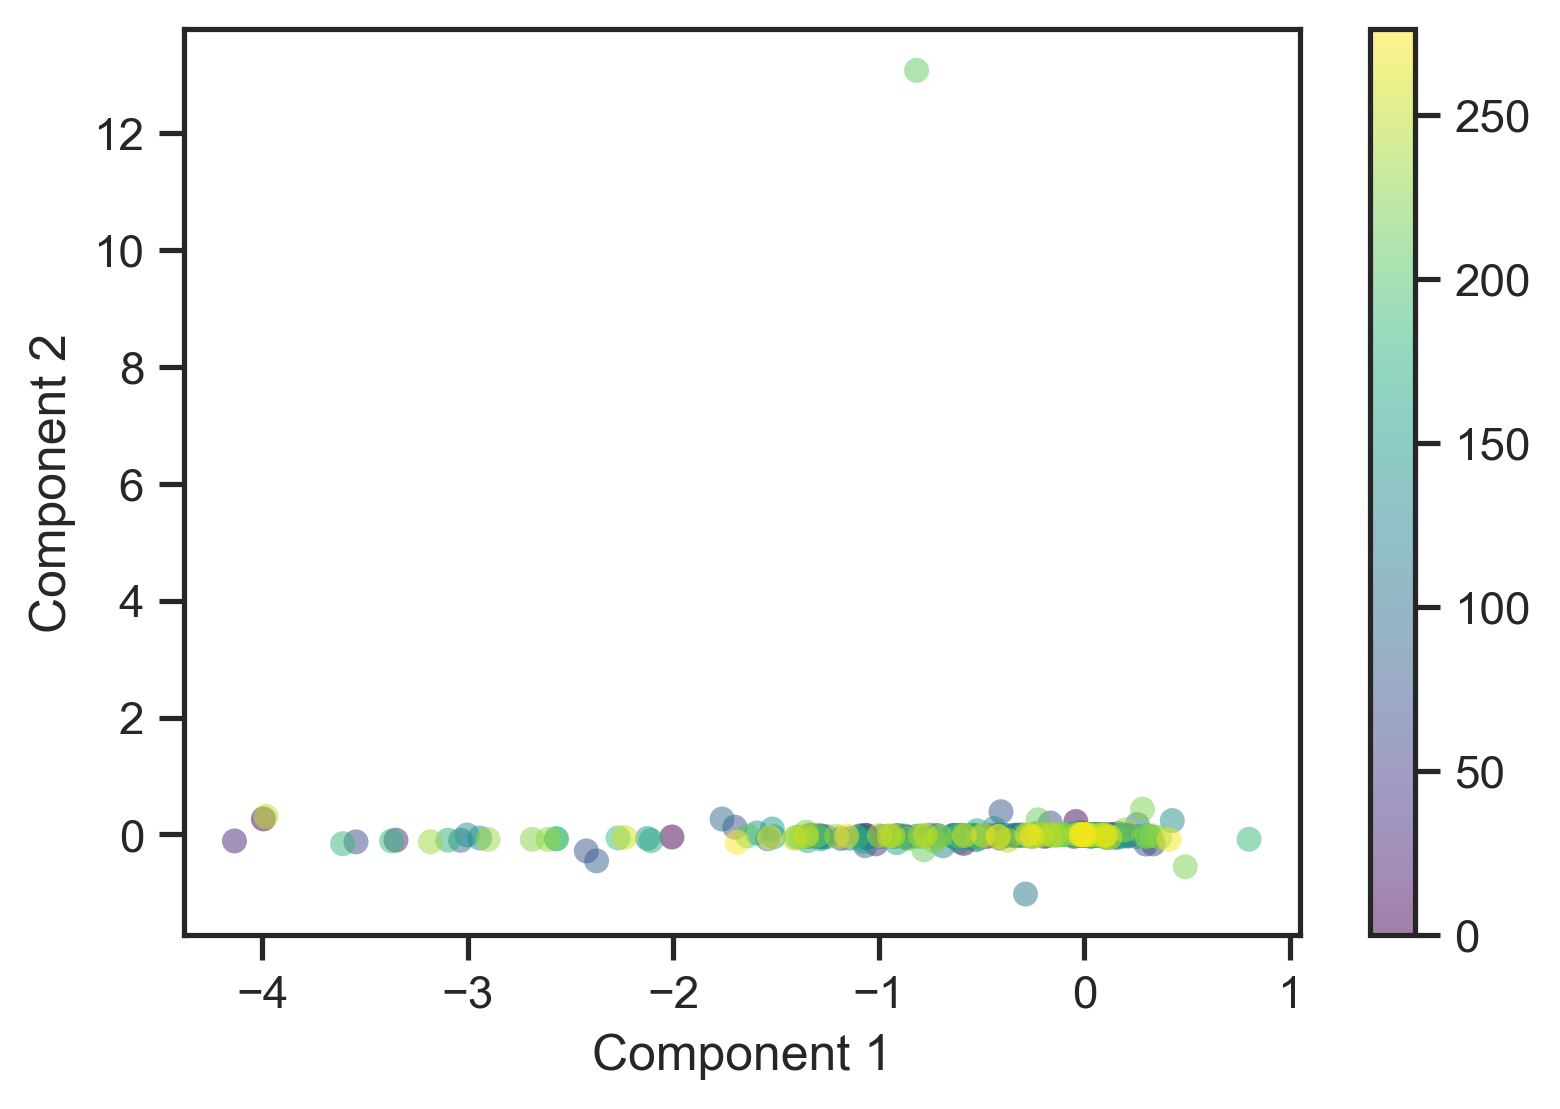

In [52]:
target = np.arange(0, M_new.shape[0])
plt.scatter(
    M_new[:, 0],
    M_new[:, 1],
    c=target,
    edgecolor='none',
    alpha=0.5,
    # cmap=plt.cm.get_cmap('spectral', 10) # Only if we have 10 classes
    cmap=plt.cm.get_cmap('viridis')
)
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.colorbar()

In [53]:
principalDf = pd.DataFrame(
    data=M_new, columns=['pc1', 'pc2']
)

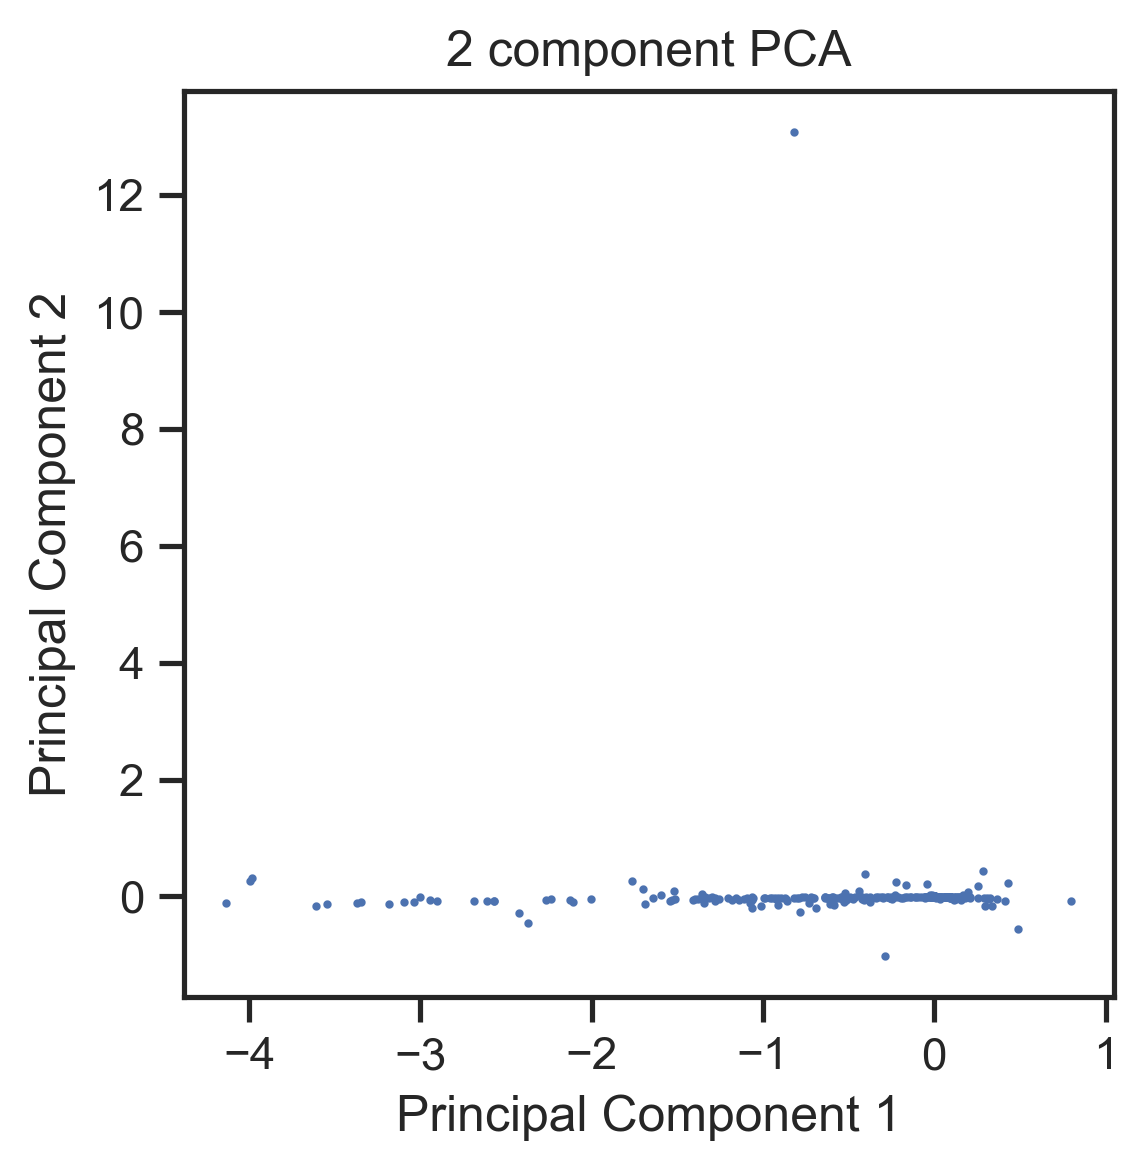

In [54]:
fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
# ax.set_xlabel('Principal Component 1', fontsize = 15)
# ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA')
# ax.set_title('2 component PCA', fontsize = 20)
ax.scatter(
    principalDf['pc1'],
    principalDf['pc2'],
    s=1
)
# ax.grid()

In [68]:
pca = PCA().fit(M_minmax.T)

In [86]:
pca.explained_variance_ratio_.shape

(277,)

In [ ]:
pca_com = []
pca_var = []
for dim in np.arange(1, M_minmax.shape[0]):
    if dim <= M_minmax.shape[0]:
        svd_solver = 'full'
    else:
        svd_solver = 'randomized'
    pca = PCA(n_components=dim, svd_solver=svd_solver).fit(M_minmax)
    pca_com.append(dim)
    pca_var.append(sum(pca.explained_variance_ratio_))
plt.plot(pca_com, pca_var)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

Text(0, 0.5, 'Cumulative explained variance')

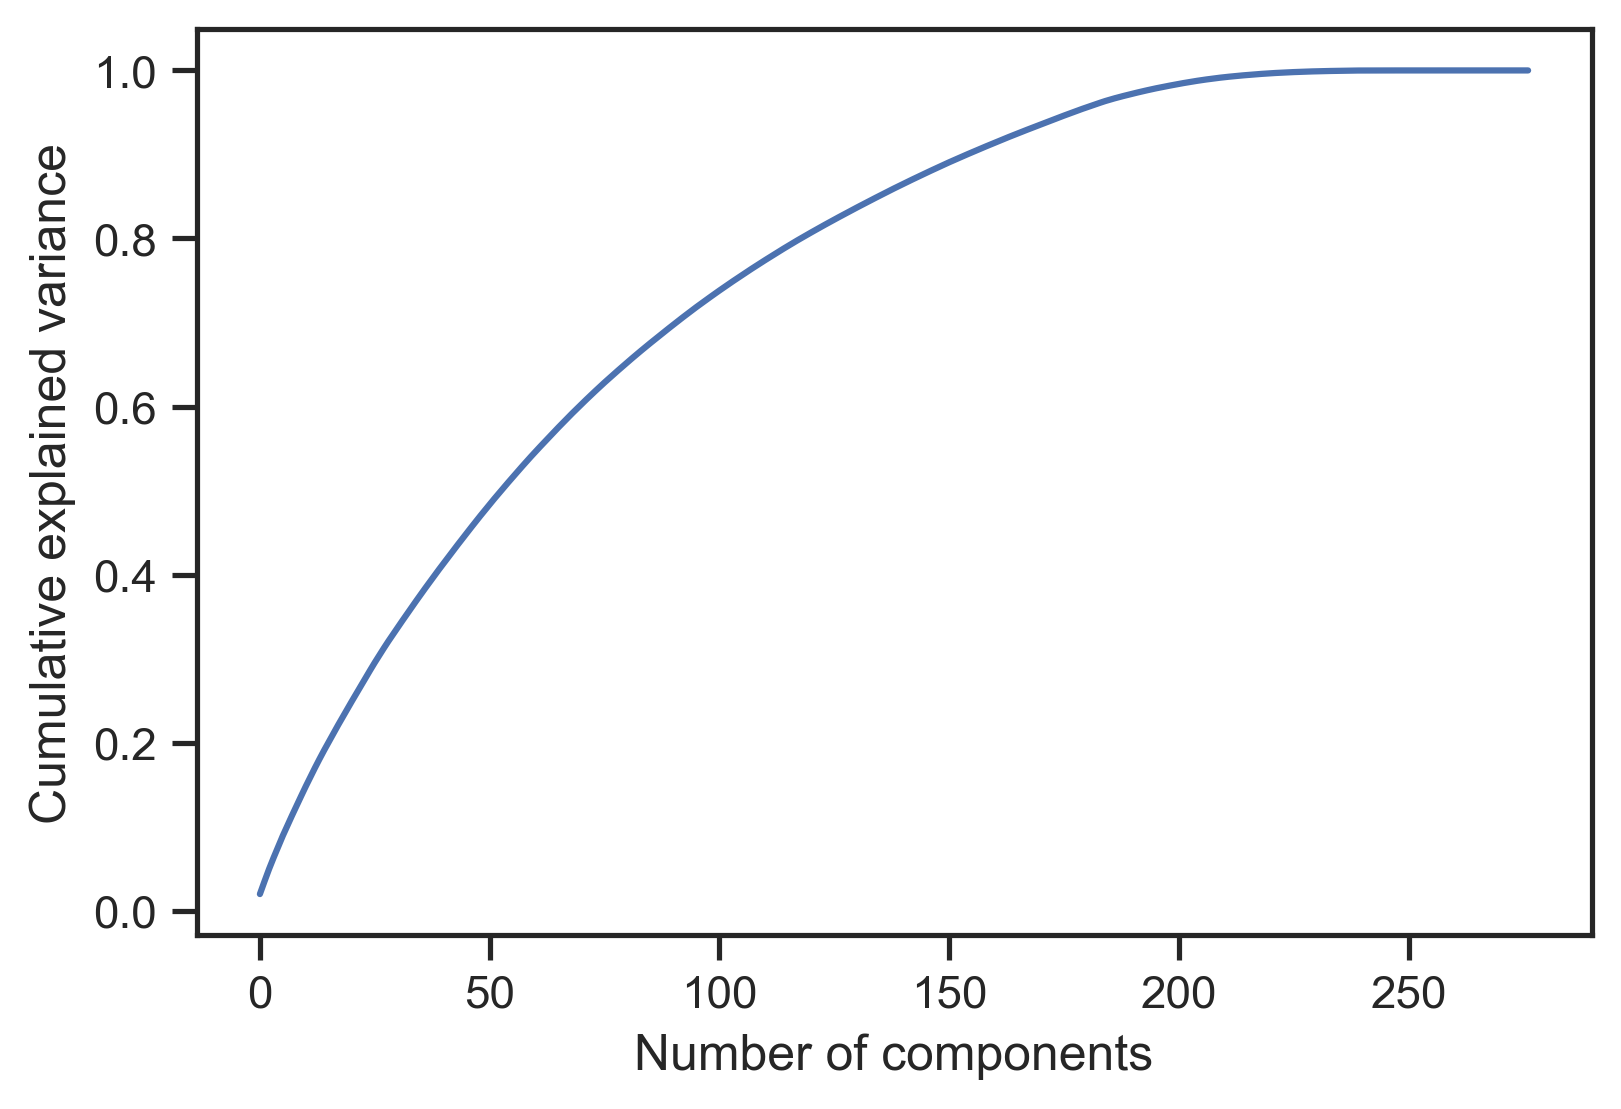

In [87]:
pca = PCA().fit(M_minmax)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')